# Data Sample Test Visualizer

In [1]:
import numpy as np
import mmwave.dsp as dsp
from mmwave.dataloader import DCA1000
import matplotlib.pyplot as plt

In [33]:
# Important Radar Scan Constants
numFrames = 50
numADCSamples = 128
numTxAntennas = 3
numRxAntennas = 4
numLoopsPerFrame = 128
numChirpsPerFrame = numTxAntennas * numLoopsPerFrame

numRangeBins = numADCSamples
numDopplerBins = numLoopsPerFrame
numAngleBins = 64
chirpPeriod = 0.06

range_resolution, bandwidth = dsp.range_resolution(numADCSamples)
doppler_resolution = dsp.doppler_resolution(bandwidth)

In [34]:
def microDoppler(dataCube):
    micro_doppler_data = np.zeros((numFrames, numLoopsPerFrame, numADCSamples), dtype=np.float64)
    for i, frame in enumerate(dataCube):
            # (2) Range Processing
            from mmwave.dsp.utils import Window

            radar_cube = dsp.range_processing(frame, window_type_1d=Window.HAMMING)
            assert radar_cube.shape == (
            numChirpsPerFrame, numRxAntennas, numADCSamples), "[ERROR] Radar cube is not the correct shape!"

            # (3) Doppler Processing 
            det_matrix , aoa_input = dsp.doppler_processing(radar_cube, num_tx_antennas=3, clutter_removal_enabled=True, window_type_2d=Window.HAMMING)

    #            # Custom signal_2_dB process, bypasses 
    #            magnitude_spectrum = np.abs(aoa_input)
    #            det_matrix = 20*np.log10(magnitude_spectrum/np.max(magnitude_spectrum))
    #            det_matrix[det_matrix<-50]=-50
    #            det_matrix = np.sum(det_matrix, axis=1)
    #            
    #            # Ensure signal is between 0 and 255 (min = -60*12, max = 0)
    #            det_matrix = (det_matrix + 720)*255/720

            # --- Show output
            det_matrix_vis = np.fft.fftshift(det_matrix, axes=1)
            micro_doppler_data[i,:,:] = det_matrix_vis

    print("done")
    # Data should now be ready. Needs to be in micro_doppler_data, a 3D-numpy array with shape [numDoppler, numRanges, numFrames]
    return micro_doppler_data.sum(axis=1).T

In [35]:
# (1) Reading in adc data
adc_data = np.fromfile('./data/dog_walking_2_2_Raw_0.bin', dtype=np.uint16)
adc_data = adc_data.reshape(numFrames, -1)
adc_data = np.apply_along_axis(DCA1000.organize, 1, adc_data, num_chirps=numChirpsPerFrame,
                                num_rx=numRxAntennas, num_samples=numADCSamples)
print("Data Loaded!")

Data Loaded!


In [36]:
uDoppler = microDoppler(adc_data)

done


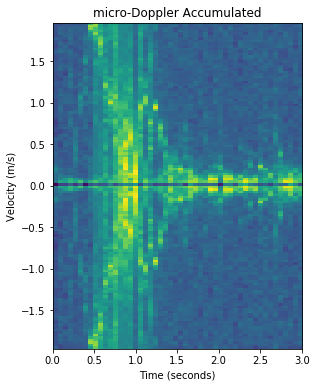

In [37]:
plt.figure(figsize=(10,6))
plt.title("micro-Doppler Accumulated")
plt.ylabel("Velocity (m/s)")
plt.xlabel("Time (seconds)")
plt.imshow(uDoppler,origin='lower',extent=(0,chirpPeriod*micro_doppler_data[:,120,:].shape[0],-micro_doppler_data[:,120,:].shape[1]*doppler_resolution/2,micro_doppler_data[:,120,:].shape[1]*doppler_resolution/2))
